In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import dask
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


### Load datasets

In [2]:
ecco = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/')

In [3]:
budgFw = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_fw_20m.nc').budg_fw
anomFw = xr.open_dataset('/mnt/efs/data/ecco/ecco_budg_anom_fw_20m.nc').budg_fw
fluxFw = xr.open_dataset('/mnt/efs/data/ecco/ecco_section_transports_fw_20m.nc')

In [4]:
anomFw.coords['term']

<xarray.DataArray 'term' (term: 13)>
array(['tendFw', 'forcFw', 'adv_ConvFw', 'adv_ConvFWe', 'adv_ConvFWb',
       'hadv_Uclim_FWanom', 'vadv_Uclim_FWanom', 'hadv_Uanom_FWclim',
       'vadv_Uanom_FWclim', 'hadv_Uanom_FWanom', 'vadv_Uanom_FWanom',
       'totalFw', 'dif_ConvFw'], dtype=object)
Coordinates:
  * term     (term) object 'tendFw' 'forcFw' ... 'totalFw' 'dif_ConvFw'

### Seasonal anomalies

In [5]:
budgFw_anom = budgFw.groupby('time.month') - budgFw.groupby('time.month').mean('time')
fluxFw_anom = fluxFw.groupby('time.month') - fluxFw.groupby('time.month').mean('time')

### Integrate anomalies

In [6]:
budgFw_int = (budgFw_anom.isel(time=slice(1, -1))*ecco.isel(time=slice(1, -1)).dt).cumsum(dim='time')
fluxFw_int = (fluxFw_anom.isel(time=slice(1, -1))*ecco.isel(time=slice(1, -1)).dt).cumsum(dim='time')
fluxFw_int['time'] = ecco.time.isel(time=slice(1, -1))

In [7]:
budgFw_int = budgFw_int.sel(time=slice('2004-01-01','2015-12-31'))
fluxFw_int = fluxFw_int.sel(time=slice('2004-01-01','2015-12-31'))

### Anomalies (from the mean)

In [8]:
budgFw_anom = budgFw_int - budgFw_int.mean('time')
fluxFw_anom = fluxFw_int - fluxFw_int.mean('time')

In [9]:
ts = [pd.to_datetime('2008-06-01'),pd.to_datetime('2010-06-01'),pd.to_datetime('2011-06-01'),
      pd.to_datetime('2012-06-01'),pd.to_datetime('2015-06-01')]

te = [pd.to_datetime('2008-10-31'),pd.to_datetime('2010-10-31'),pd.to_datetime('2011-10-31'),
      pd.to_datetime('2012-10-31'),pd.to_datetime('2015-10-31')]

In [10]:
for a,b in zip(ts,te):
    print(a)

2008-06-01 00:00:00
2010-06-01 00:00:00
2011-06-01 00:00:00
2012-06-01 00:00:00
2015-06-01 00:00:00


In [102]:
budgFw_anom.coords['term']

<xarray.DataArray 'term' (term: 17)>
array(['tendFw', 'forcFw', 'adv_hConvFWe', 'adv_vConvFWe', 'adv_ConvFWe',
       'adv_hConvFWb', 'adv_vConvFWb', 'adv_ConvFWb', 'adv_hConvFw',
       'adv_vConvFw', 'adv_ConvFw', 'totalFw', 'w_trspFWe', 'w_trspFWb',
       'lfwc', 'psal', 'dif_ConvFw'], dtype=object)
Coordinates:
  * term     (term) object 'tendFw' 'forcFw' ... 'psal' 'dif_ConvFw'

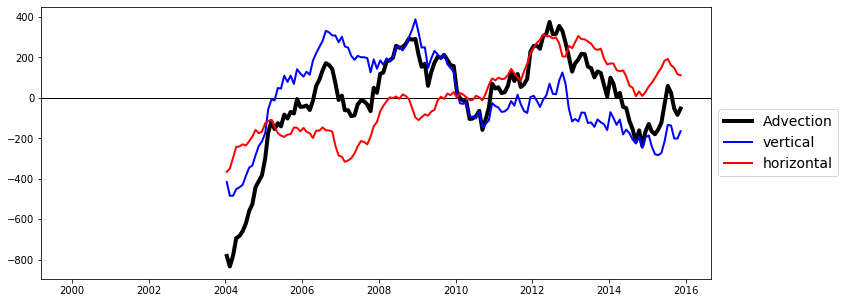

In [105]:
fig, ax = plt.subplots(figsize=(12,5))

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budgFw_anom.time, budgFw_anom.sel(region='lsea',term='adv_ConvFw')*1e-3, lw=4, color='black',label='Advection')
ax.plot(budgFw_anom.time, budgFw_anom.sel(region='lsea',term='adv_vConvFw')*1e-3, lw=2, color='blue',label='vertical')
ax.plot(budgFw_anom.time, budgFw_anom.sel(region='lsea',term='adv_hConvFw')*1e-3, lw=2, color='red',label='horizontal')
ax.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14)

plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


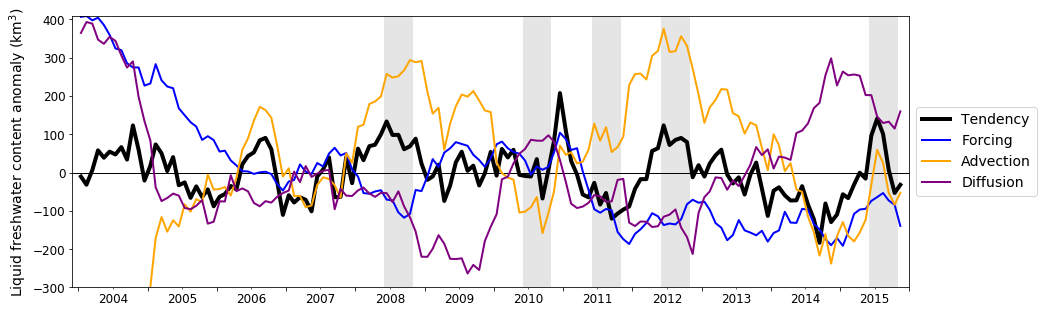

In [11]:
fig, ax = plt.subplots(figsize=(12,5))

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budgFw_anom.time, budgFw_anom.sel(region='lsea',term='tendFw')*1e-3, lw=4, color='black',label='Tendency')
ax.plot(budgFw_anom.time, budgFw_anom.sel(region='lsea',term='forcFw')*1e-3, lw=2, color='blue',label='Forcing')
ax.plot(budgFw_anom.time, budgFw_anom.sel(region='lsea',term='adv_ConvFw')*1e-3, 
        lw=2, color='orange',label='Advection')
ax.plot(budgFw_anom.time, budgFw_anom.sel(region='lsea',term='dif_ConvFw')*1e-3, 
        lw=2, color='purple',label='Diffusion')

ax.axvspan('2008-06-01','2008-10-31',facecolor='grey', alpha=0.2, edgecolor='None')
ax.axvspan('2010-06-01','2010-10-31',facecolor='grey', alpha=0.2, edgecolor='None') 


#,alpha=.5,color='red')
ax.axvspan('2011-06-01','2011-10-31',facecolor='grey', alpha=0.2, edgecolor='None')
#,alpha=.5,color='red')
ax.axvspan('2012-06-01','2012-10-31',facecolor='grey', alpha=0.2, edgecolor='None')
#,alpha=.5,color='red')
ax.axvspan('2015-06-01','2015-10-31',facecolor='grey', alpha=0.2, edgecolor='None')

#,alpha=.5,color='red')
    
ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(12)

ax.set_xlim(['2003-12-01','2016-01-01'])
ax.set_ylim([-300,410])

ax.set_ylabel('Liquid freshwater content anomaly (km$^3$)',fontsize=14)

ax.yaxis.set_tick_params(labelsize=12)
ax.legend(loc='center left',bbox_to_anchor=(1, 0.5),fontsize=14,frameon)
    
plt.savefig('/mnt/efs/figure.png')
plt.savefig('/mnt/efs/figure.eps')
plt.savefig('/mnt/efs/figure.pdf')
plt.show()

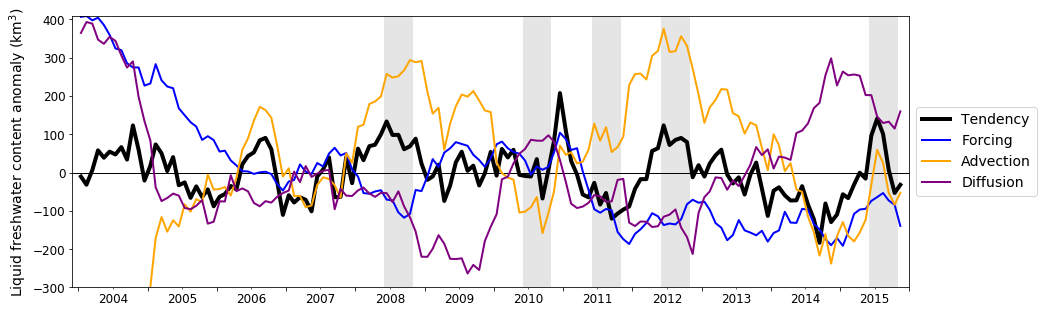

In [110]:
df = pd.read_csv('/mnt/efs/data/df_psi_spg_box.csv')
df.time = pd.DatetimeIndex(df.time)
df = df.drop('Unnamed: 0', 1)

In [111]:
df['adv_ConvFw'] = budgFw.sel(region='lsea',term='adv_ConvFw').to_dataframe().reset_index()['budg_fw']
df['adv_hConvFw'] = budgFw.sel(region='lsea',term='adv_hConvFw').to_dataframe().reset_index()['budg_fw']

In [112]:
df.set_index('time',inplace=True)

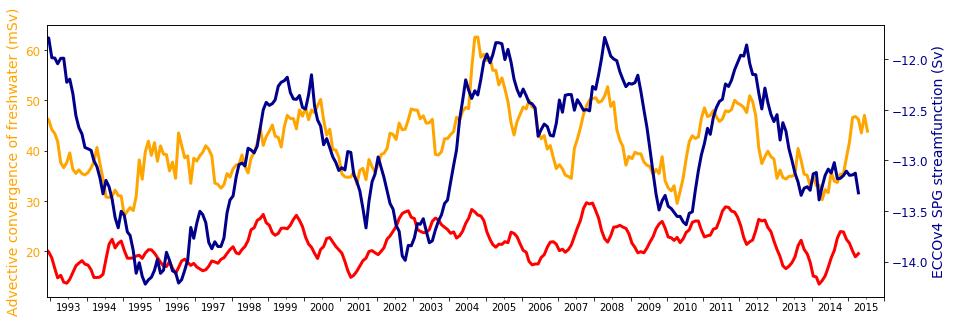

In [114]:
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.plot(df.index, df.adv_hConvFw.rolling(window=18,center=True).mean()*1e3,lw=3, color='red',linestyle='-')
ax1.plot(df.index, df.adv_ConvFw.rolling(window=12,center=True).mean()*1e3, lw=3, color='orange',label='Tendency')

ax1.set_xlim(['1992-12-01','2016-01-01'])
ax1.set_ylabel(r'Advective convergence of freshwater (mSv)',color='orange',fontsize=14)

for tl in ax1.get_yticklabels():
    tl.set_color('orange')
    tl.set_fontsize(12)
    
ax1.xaxis.set_major_locator(dates.YearLocator())
ax1.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax1.xaxis.set_major_formatter(ticker.NullFormatter())
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax1.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax2 = ax1.twinx()
ax2.plot(df.index, df.psi_spg.rolling(window=18,center=True).mean(),
         lw=3, color='darkblue',linestyle='-')
ax2.set_xlim(['1992-12-01','2016-01-01'])
ax2.set_ylabel('ECCOv4 SPG streamfunction (Sv)',color='darkblue',fontsize=14)
for tl in ax2.get_yticklabels():
    tl.set_color('darkblue')
    tl.set_fontsize(12)

ax2.xaxis.set_major_locator(dates.YearLocator())
ax2.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax2.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)
    
#plt.savefig('/tmp/figure.png')
plt.show()

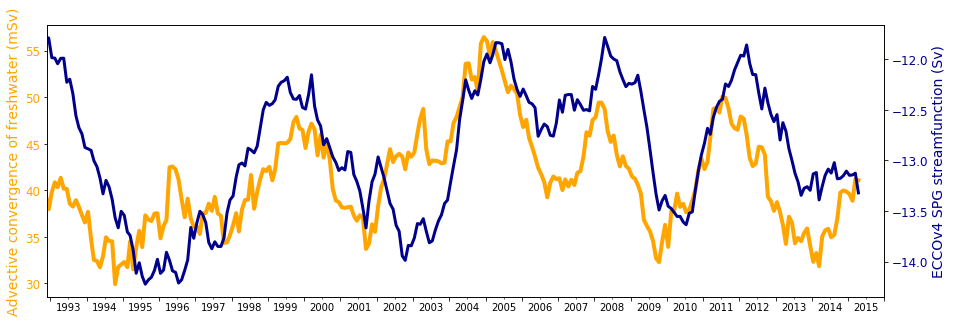

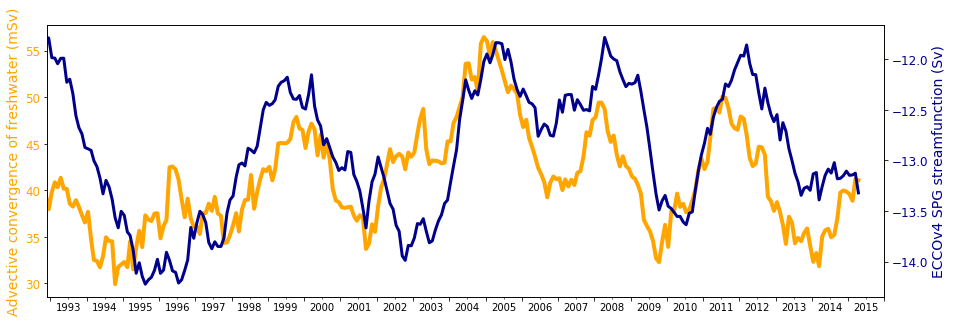

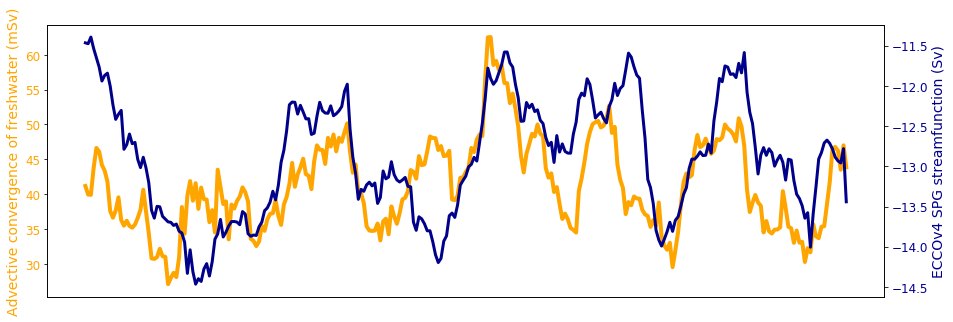

In [64]:
from scipy.stats.stats import pearsonr

In [100]:
pearsonr(df.rolling(window=18,center=True).mean().dropna().adv_ConvFw, 
         df.rolling(window=18,center=True).mean().dropna().psi_spg)

(0.5825904564153366, 4.9996534386445853e-26)

(0.5458949946183113, 6.492167647490612e-23)

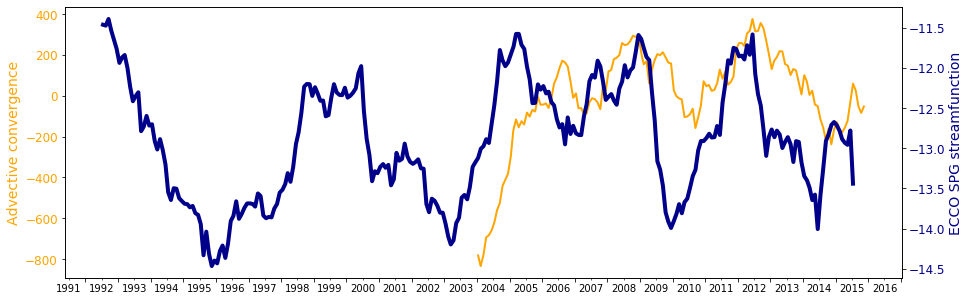

In [24]:
fig, ax1 = plt.subplots(figsize=(15,5))

ax1.plot(budgFw_anom.time, budgFw_anom.sel(region='lsea',term='adv_ConvFw')*1e-3, 
        lw=2, color='orange',label='Advection')
#ax1.set_xlim(['2003-12-01','2016-01-01'])
ax1.set_ylabel(r'Advective convergence',color='orange',fontsize=14)
for tl in ax1.get_yticklabels():
    tl.set_color('orange')
    tl.set_fontsize(12)
    
ax1.xaxis.set_major_locator(dates.YearLocator())
ax1.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax1.xaxis.set_major_formatter(ticker.NullFormatter())
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax1.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)
#ax1.set_ylim([-300,410])

ax2 = ax1.twinx()
ax2.plot(df.index, df.psi_spg.rolling(window=12,center=True).mean(),
         lw=4, color='darkblue',linestyle='-')
#ax2.set_xlim(['2003-12-01','2016-01-01'])
ax2.set_ylabel('ECCO SPG streamfunction',color='darkblue',fontsize=14)
for tl in ax2.get_yticklabels():
    tl.set_color('darkblue')
    tl.set_fontsize(12)

ax2.xaxis.set_major_locator(dates.YearLocator())
ax2.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax2.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)
#plt.savefig('/tmp/figure.png')
plt.show()

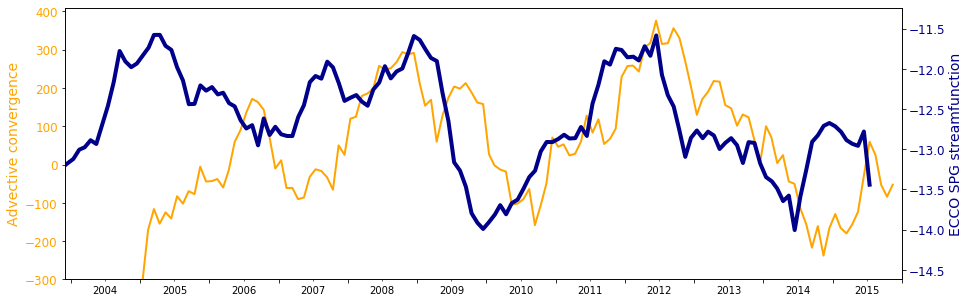